### Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import  numpy as np
import pandas as pd
import tweepy, codecs
import tokens

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from warnings import filterwarnings
filterwarnings('ignore')

## Twitterlə bağlantının qurulub, datanın API üzərindən alınması

In [2]:
consumer_key = tokens.consumer_key
consumer_secret = tokens.consumer_secret
access_token = tokens.access_token
access_token_secret = tokens.access_token_secret


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
tweets = api.search_tweets(q=['Texnologiya'], count = 1000)

In [4]:
def hashtag_df(tweets):
    import pandas as pd
    id_list = [tweet.id for tweet in tweets]
    print(id_list)
    df = pd.DataFrame(id_list, columns = ["id"])
    
    df["text"] = [tweet.text for tweet in  tweets]
    df["retweet_count"] = [tweet.retweet_count for tweet in  tweets]
    df["user_screen_name"] = [tweet.author.screen_name for tweet in  tweets]
    df["user_location"] = [tweet.author.location for tweet in  tweets]
    df["Hashtags"] = [tweet.entities.get('hashtags') for tweet in  tweets]
    
    return df

In [5]:
df = hashtag_df(tweets)

[1556252861683666945, 1556225182569750528, 1556194993521496064, 1555932262620958722, 1555887411032477696, 1555830851606306816, 1555781591619801090, 1555780782886715393, 1555678195747258369, 1555624437864493056, 1555612224089210882, 1555595836654030848, 1555539417946791936, 1555530380068921348, 1555473394644135941, 1555416408313532417, 1555415632312770562, 1555201872272793601, 1555188007140990977, 1555061042966921216, 1555043585313095681, 1554892956636684291, 1554825672949768193, 1554814650713358336, 1554776997561307136, 1554765808638763009, 1554749371979268099, 1554464356116611075, 1554104501027700736, 1554083457625722882, 1554083025813741574, 1554078186711007234, 1554029028260155392, 1553705385206374401, 1553582207326978048, 1553582179153764352, 1553446897636999168, 1553446851931684864, 1553416170862166016, 1553400793092329477, 1553393398064758785, 1553379931505188865, 1553359072661016576, 1553324439781138432, 1553254344367251456, 1553192820139237377, 1553106185229836289, 155296235078

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                49 non-null     int64 
 1   text              49 non-null     object
 2   retweet_count     49 non-null     int64 
 3   user_screen_name  49 non-null     object
 4   user_location     49 non-null     object
 5   Hashtags          49 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.4+ KB


In [7]:
df.head()

,id,text,retweet_count,user_screen_name,user_location,Hashtags
0,1556252861683666945,gəncə texnologiya universiteti ya aqrar? ixtis...,0,soganchorey,,[]
1,1556225182569750528,@iguanazrin BMU Texnologiya və tədrisi yüksəkdir,0,NarmiiT,Azerbaijan,[]
2,1556194993521496064,Mana buni texnologiya desa bo'ladi\nhttps://t....,0,mahmud0v_77,,[]
3,1555932262620958722,Əslində aya sərt eniş edə biləcək texnologiya ...,0,UrfanMammad,,[]
4,1555887411032477696,"Menimcha, Xudoni borligini ham yoʻqligini ham ...",0,collapsusvulpes,Heaven,[]


In [8]:
df["user_screen_name"].unique().size

36

In [9]:
# import dill

# dill.dump_session('twtr.pkl')

In [10]:
# import dill

# dill.load_session('twtr.pkl')

In [11]:
df[~df.text.str.startswith('RT')].count().id / len(df)

0.7551020408163265

In [12]:
#Some Russian and other text
import re

raws_to_drop = list()

def has_cyrillic(text):
    return bool(re.search('[\u0400-\u04FF]', text))
    
for i in df['text']:
    if has_cyrillic(i):
        raws_to_drop.append(df.loc[df['text'] == i].index.values[0])
    
raws_to_drop
df.drop(df.index[raws_to_drop], inplace=True)

## Textin ingilis dilinə tərcüməsi və bəzi düzəlişlər

In [13]:
import translators as ts

df['text_en'] = df['text'].apply(lambda x: ts.google(x, from_language='az', to_language='en' ))

Using Azerbaijan server backend.


In [14]:
df['text_en'] = df['text_en'].apply(lambda x: " ".join(x.lower() for x in x.split()))


df['text_en'] = df['text_en'].str.replace('[^\w\s]','')


df['text_en'] = df['text_en'].str.replace('\d','')


import nltk

from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text_en'] = df['text_en'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

from textblob import Word

df['text_en'] = df['text_en'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 


df['text_en'] = df['text_en'].str.replace('rt','')

# Deleting links in tweets
df['text_en'] = df['text_en'].apply(lambda x: ' '.join([i for i in x.split() if not str(i).startswith('http')]))

In [15]:
df.text_en.values

array(['ganja technology university agrarian qualification componence',
       'iguanazrin bmu technology teaching high',
       'mana bun technology desa boladi',
       'fact technology make tough landing moon difficult theme made satellite make soft landing',
       'menimcha khudoni borligini ham yogligini ham isbotlab technology rabbills fagattgina materiyag',
       'adgozelovf gaga read adnsu recommend basis gkf energy ktf economy',
       'asanvolunteers easy volunteer took pa examination exam deneyap technology laboratory thefs easiers',
       'asanvolunteers deneap bilim baku technology laboratory suppo examination exam student selection student',
       'als_ president ilham aliyev dismissed akif shamil oglu suleymanov position rector azerbaijan technology university',
       'r_shokh yangi technology mayli shunchaki yangi version chiqa yurak orgaga toali',
       'dastlab ga radi koygan paytes yangi technology organishga im balanced hozirga kelib',
       'attention citize

In [16]:
df

,id,text,retweet_count,user_screen_name,user_location,Hashtags,text_en
0,1556252861683666945,gəncə texnologiya universiteti ya aqrar? ixtis...,0,soganchorey,,[],ganja technology university agrarian qualifica...
1,1556225182569750528,@iguanazrin BMU Texnologiya və tədrisi yüksəkdir,0,NarmiiT,Azerbaijan,[],iguanazrin bmu technology teaching high
2,1556194993521496064,Mana buni texnologiya desa bo'ladi\nhttps://t....,0,mahmud0v_77,,[],mana bun technology desa boladi
3,1555932262620958722,Əslində aya sərt eniş edə biləcək texnologiya ...,0,UrfanMammad,,[],fact technology make tough landing moon diffic...
4,1555887411032477696,"Menimcha, Xudoni borligini ham yoʻqligini ham ...",0,collapsusvulpes,Heaven,[],menimcha khudoni borligini ham yogligini ham i...
5,1555830851606306816,@adgozelovf23 Qaqa mən Adnsu'da oxuyuram ona g...,0,tghyvrshd,"New York, USA",[],adgozelovf gaga read adnsu recommend basis gkf...
6,1555781591619801090,RT @asanvolunteers: “Deneyap” texnologiya labo...,1,tabriz107,,"[{'text': 'AKT', 'indices': [117, 121]}, {'tex...",asanvolunteers easy volunteer took pa examinat...
7,1555780782886715393,RT @asanvolunteers: #Deneyap (Bilim Bakı) texn...,2,tabriz107,,"[{'text': 'Deneyap', 'indices': [20, 28]}]",asanvolunteers deneap bilim baku technology la...
8,1555678195747258369,RT @YAP_1992: Prezident İlham Əliyev Akif Şami...,96,QarayevaAygul,,[],als_ president ilham aliyev dismissed akif sha...
9,1555624437864493056,@r_shokh95 Yangi texnologiya mayli Shunchaki y...,0,6rtacha,"Gwangju, South Korea",[],r_shokh yangi technology mayli shunchaki yangi...


In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [18]:
text = ' '.join([i for i in df['text_en']])

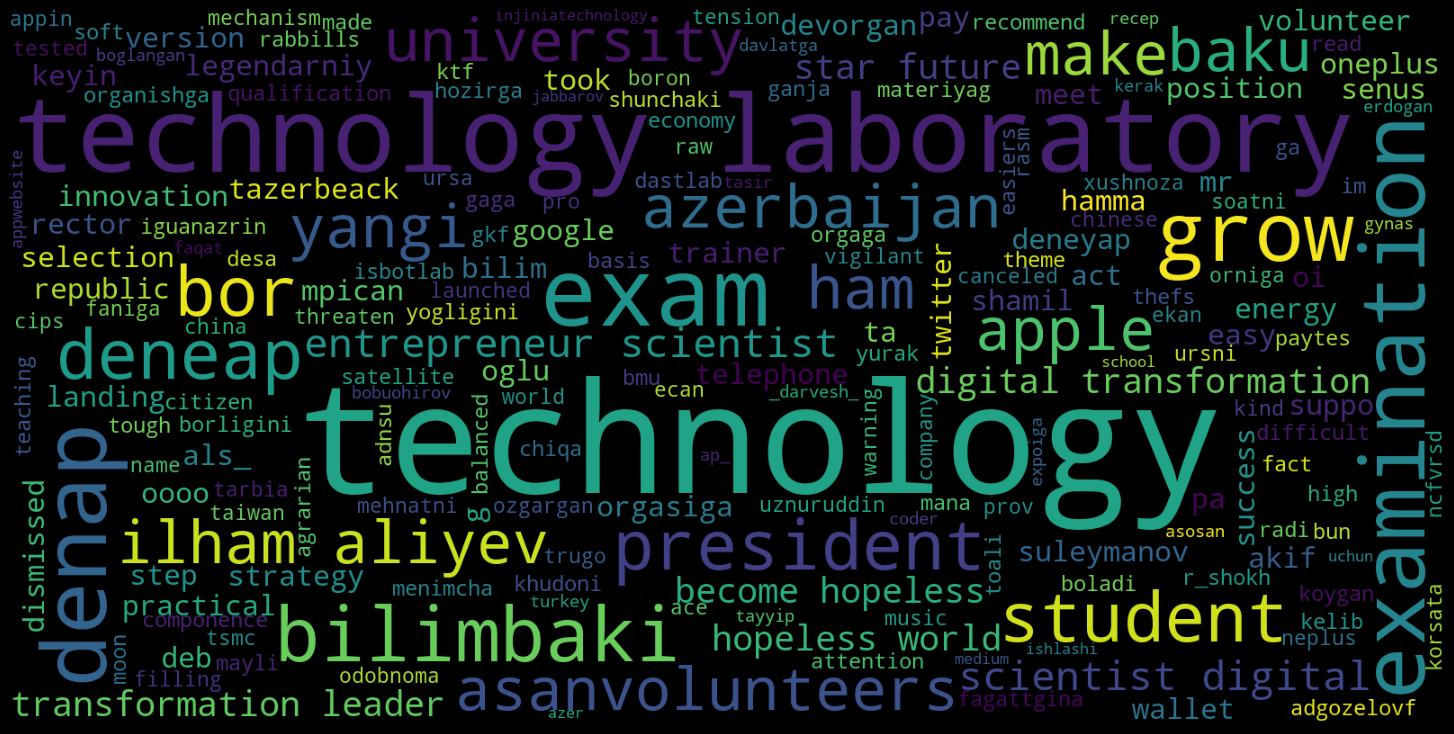

In [19]:
wordcloud = WordCloud(width=1600, height=800).generate(text)


plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [20]:
def score(df):

    text = df["text_en"]
    
    emo, scr  = [], []
    
    for i in text:

        textB = TextBlob(i)
        score = textB.sentiment.polarity
        scr.append(score)

        if score <0.00:
            emo.append('Negative')

        elif score >0.00:
            emo.append('Positive')

        else:
            emo.append('Neutral')


    df['sentiment_score'] = scr
    df['emotion_class'] = emo
        
    return df 

In [21]:
score(df)

,id,text,retweet_count,user_screen_name,user_location,Hashtags,text_en,sentiment_score,emotion_class
0,1556252861683666945,gəncə texnologiya universiteti ya aqrar? ixtis...,0,soganchorey,,[],ganja technology university agrarian qualifica...,0.000000,Neutral
1,1556225182569750528,@iguanazrin BMU Texnologiya və tədrisi yüksəkdir,0,NarmiiT,Azerbaijan,[],iguanazrin bmu technology teaching high,0.160000,Positive
2,1556194993521496064,Mana buni texnologiya desa bo'ladi\nhttps://t....,0,mahmud0v_77,,[],mana bun technology desa boladi,0.000000,Neutral
3,1555932262620958722,Əslində aya sərt eniş edə biləcək texnologiya ...,0,UrfanMammad,,[],fact technology make tough landing moon diffic...,-0.262963,Negative
4,1555887411032477696,"Menimcha, Xudoni borligini ham yoʻqligini ham ...",0,collapsusvulpes,Heaven,[],menimcha khudoni borligini ham yogligini ham i...,0.000000,Neutral
5,1555830851606306816,@adgozelovf23 Qaqa mən Adnsu'da oxuyuram ona g...,0,tghyvrshd,"New York, USA",[],adgozelovf gaga read adnsu recommend basis gkf...,0.000000,Neutral
6,1555781591619801090,RT @asanvolunteers: “Deneyap” texnologiya labo...,1,tabriz107,,"[{'text': 'AKT', 'indices': [117, 121]}, {'tex...",asanvolunteers easy volunteer took pa examinat...,0.433333,Positive
7,1555780782886715393,RT @asanvolunteers: #Deneyap (Bilim Bakı) texn...,2,tabriz107,,"[{'text': 'Deneyap', 'indices': [20, 28]}]",asanvolunteers deneap bilim baku technology la...,0.000000,Neutral
8,1555678195747258369,RT @YAP_1992: Prezident İlham Əliyev Akif Şami...,96,QarayevaAygul,,[],als_ president ilham aliyev dismissed akif sha...,0.000000,Neutral
9,1555624437864493056,@r_shokh95 Yangi texnologiya mayli Shunchaki y...,0,6rtacha,"Gwangju, South Korea",[],r_shokh yangi technology mayli shunchaki yangi...,0.000000,Neutral


<AxesSubplot:xlabel='emotion_class', ylabel='count'>

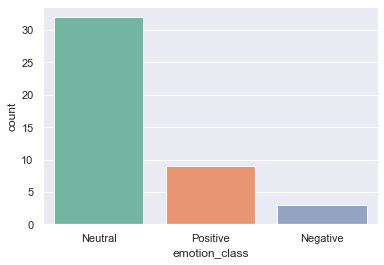

In [22]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.countplot(x='emotion_class', data=df, palette="Set2")

## Sentiment təxmini üçün sadə model
* data az olduğundan o qədərdə yaxşı alınmadı

In [23]:

data = pd.DataFrame()

data['text'] = df['text_en']
data['label'] = df['emotion_class']

In [24]:
for i in range(100):

    train_x, test_x, train_y, test_y = model_selection.train_test_split(data['text'], data['label'], random_state=i)
    encoder = preprocessing.LabelEncoder()
    train_y = encoder.fit_transform(train_y)
    test_y = encoder.fit_transform(test_y)
    
    
    # Vectorizer
    
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    
    x_train_vec = vectorizer.transform(train_x)
    x_test_vec = vectorizer.transform(test_x)
    
    
    #Regression
    
    reg = linear_model.LogisticRegression()
    reg_model = reg.fit(x_train_vec,train_y)

    try:
        accuracy = model_selection.cross_val_score(reg_model, 
                                           x_test_vec, 
                                           test_y).mean()


        if accuracy > 0.8:
            print(f'Accuracy: {accuracy:.2f}')
            break
    except: pass        
   

Accuracy: 0.83


# Technote.az üzərindən sentiment analizi

In [25]:
urls = list()
for page in range(1, 150):
    
    base_url = f'https://technote.az/axtar?q=Azərbaycanda%20texnologiya&page={page}'
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'lxml')
    news = [i for i in soup.find_all('div', {'class': 'item-news'})]
    urls.append([i.find('a').get('href') for i in news])


    page += 1

urls = [i for sublist in urls for i in sublist]

In [26]:
texts = list()

for url in urls:
    base_url = f'https://technote.az/{url}'
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'lxml')
    newscontent = soup.find('div', {'id': 'news-content'})
    text = ''.join([i.text for i in newscontent.find_all('div', {'class': None})])
    
    if text == '':
        text = ''.join([i.text for i in newscontent.find_all('p', {'class': None})])
        
    texts.append(text)

In [27]:
def to_df(texts):

    df = pd.DataFrame()
    
    df['text'] = [text for text in texts]
    
    return df

In [28]:
df = to_df(texts)

In [29]:
df.dropna(inplace=True)

In [30]:
import translators as ts

df['text_en'] = df['text'].apply(lambda x: ts.google(x[:2500], from_language='az', to_language='en' ))

In [31]:
df['text_en'] = df['text_en'].apply(lambda x: " ".join(x.lower() for x in x.split()))


df['text_en'] = df['text_en'].str.replace('[^\w\s]','')


df['text_en'] = df['text_en'].str.replace('\d','')


import nltk

from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text_en'] = df['text_en'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

from textblob import Word

df['text_en'] = df['text_en'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 


df['text_en'] = df['text_en'].str.replace('rt','')

# Deleting links in tweets
df['text_en'] = df['text_en'].apply(lambda x: ' '.join([i for i in x.split() if not str(i).startswith('http')]))

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

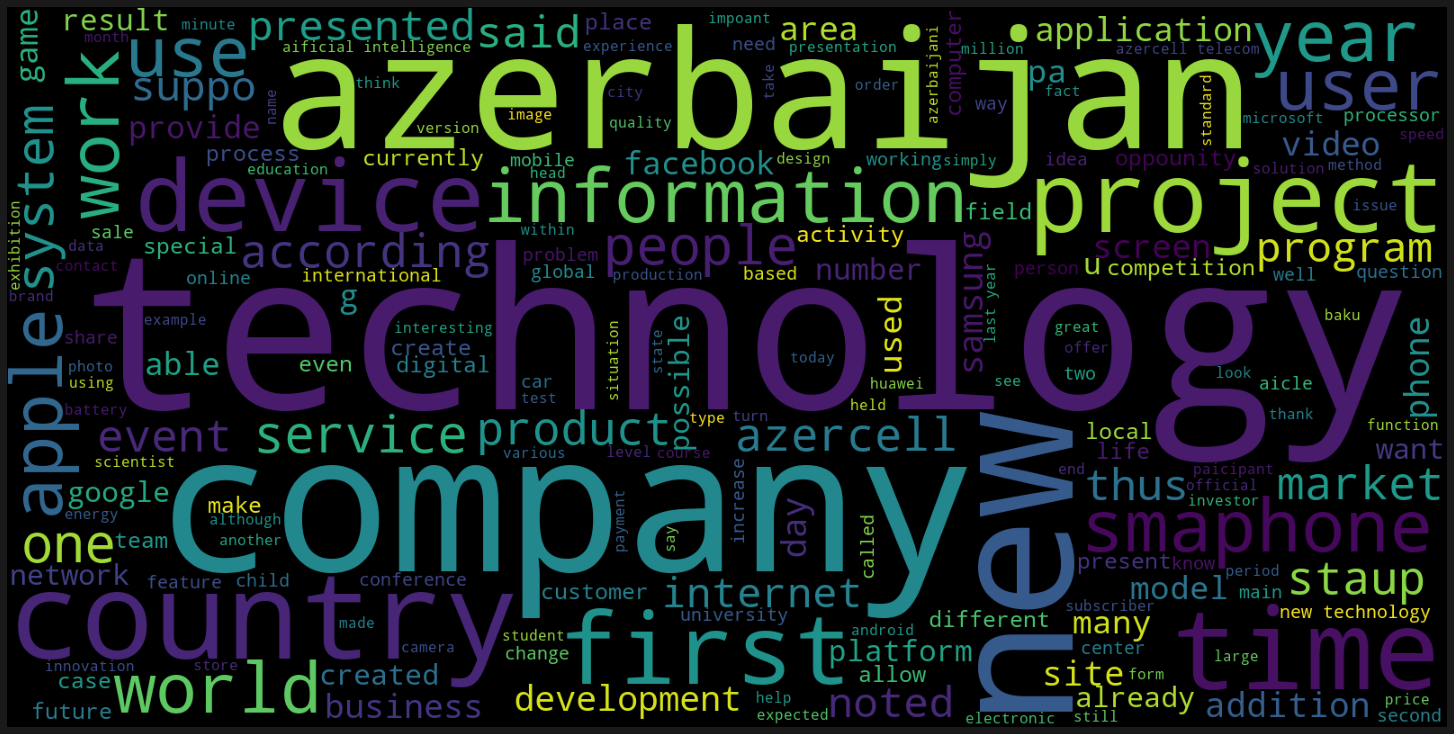

In [33]:
text = ' '.join([i for i in df['text_en']])
wordcloud = WordCloud(width=1600, height=800).generate(text)


plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [34]:
def score(df):

    text = df["text_en"]
    
    emo, scr  = [], []
    
    for i in text:

        textB = TextBlob(i)
        score = textB.sentiment.polarity
        scr.append(score)

        if score <0.00:
            emo.append('Negative')

        elif score >0.00:
            emo.append('Positive')

        else:
            emo.append('Neutral')


    df['sentiment_score'] = scr
    df['sentiment_class'] = emo
        
    return df 

In [35]:
score(df)

,text,text_en,sentiment_score,sentiment_class
0,Amerika Birləşmiş Ştatları və İran arasında uz...,continuing discussion finally announced united...,0.081757,Positive
1,Sorğunun üçüncü hissəsi məhz sorğuda işti...,third pa survey related programming programmer...,0.084722,Positive
2,Qısa bir zamanda azərbaycanlı gamer\'lərin sev...,sho favorite azerbaijani gamer gamesap favorit...,0.132800,Positive
3,2017-ci ilin artıq geridə qoyduq. Ötən ili...,already left behind last year considered impoa...,-0.011537,Negative
4,2 ildən çoxdur Azərbaycan bazarında doğma ...,year technology information poal technology op...,0.183929,Positive
...,...,...,...,...
591,Bloomberg redaksiyası bu həftə çıxacaq yeni St...,bloomberg editorial office prepared power stat...,0.057051,Positive
592,Qulaqlıq taxmadan da musiqi dinləməyinizə şəra...,vue creates way listen music without wearing h...,0.274405,Positive
593,,,0.000000,Neutral
594,Startaplar üçün əsas seçim kriteriyalarında la...,global regional orientation project main selec...,0.252681,Positive


<AxesSubplot:xlabel='sentiment_class', ylabel='count'>

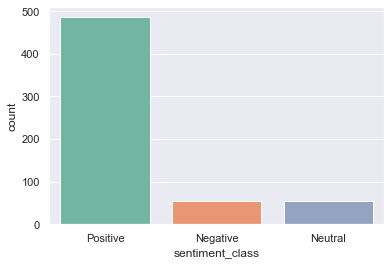

In [36]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.countplot(x='sentiment_class', data=df, palette="Set2")

In [41]:
df.groupby(by='sentiment_class').count()

,text,text_en,sentiment_score
sentiment_class,,,
Negative,55,55,55
Neutral,55,55,55
Positive,486,486,486
